# Run through one sequence, use the sequence class

In [1]:
!mkdir -p /scratch/aneesh

In [1]:
!mkdir -p /scratch/aneesh

import os, sys

sys.path.append(os.path.join(os.getcwd(), "Grounded-Segment-Anything"))
sys.path.append(os.path.join(os.getcwd(), "Grounded-Segment-Anything", "GroundingDINO"))
sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
sys.path.append(os.path.join(os.getcwd(), "recognize-anything"))

print(os.getcwd(), os.path.join(os.getcwd(), "Grounded-Segment-Anything", "GroundingDINO"))
print(sys.path)

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# recognise anything
from ram.models import ram
from ram import inference_ram as inference
from ram import get_transform

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

import os

# load models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

/home2/aneesh.chavan/Change_detection /home2/aneesh.chavan/Change_detection/Grounded-Segment-Anything/GroundingDINO
['/home2/aneesh.chavan/Change_detection', '/home2/aneesh.chavan/miniconda3/envs/reid/lib/python310.zip', '/home2/aneesh.chavan/miniconda3/envs/reid/lib/python3.10', '/home2/aneesh.chavan/miniconda3/envs/reid/lib/python3.10/lib-dynload', '', '/home2/aneesh.chavan/miniconda3/envs/reid/lib/python3.10/site-packages', '/home2/aneesh.chavan/Change_detection/recognize-anything', '/home2/aneesh.chavan/Change_detection/Grounded-Segment-Anything', '/home2/aneesh.chavan/Change_detection/Grounded-Segment-Anything/GroundingDINO', '/home2/aneesh.chavan/Change_detection/GroundingDINO', '/home2/aneesh.chavan/Change_detection/recognize-anything']


In [2]:
# load models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [4]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home2/aneesh.chavan/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


### RAM

In [5]:
import os

# if not os.path.isfile("/scratch/aneesh/ram_swin_large_14m.pth"):
# !wget -O /scratch/aneesh/ram_swin_large_14m.pth https://huggingface.co/spaces/xinyu1205/recognize-anything/resolve/main/ram_swin_large_14m.pth

# r = ram(image_size=384, vit='swin_l')
# ram_model = ram(pretrained='/scratch/aneesh/ram_swin_large_14m.pth', image_size=384, vit='swin_l')
# ram_model.eval()
# ram_model.to(device)

In [6]:
# import matplotlib.pyplot as plt

# test_img_path = '/home2/aneesh.chavan/Change_detection/360_zip/view2/view2.png'
# transform = get_transform(image_size=384)
# image = transform(Image.open(test_img_path)).unsqueeze(0).to(device)

# res = inference(image, ram_model)
# print("Image Tags: ", res[0])

# plt.imshow(Image.open(test_img_path));


### Grounding DINO for detection

In [3]:
# ! wget -O /scratch/aneesh/sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = '/scratch/aneesh/sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

In [8]:
# detect object using grounding DINO
def detect(image, text_prompt, model, image_source=None, box_threshold = 0.35, text_threshold = 0.55, remove_combined=False):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  if type(image_source) == None:
    annotated_frame = None
  else:
    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    annotated_frame = annotated_frame[...,::-1] # BGR to RGB

  return annotated_frame, boxes, phrases

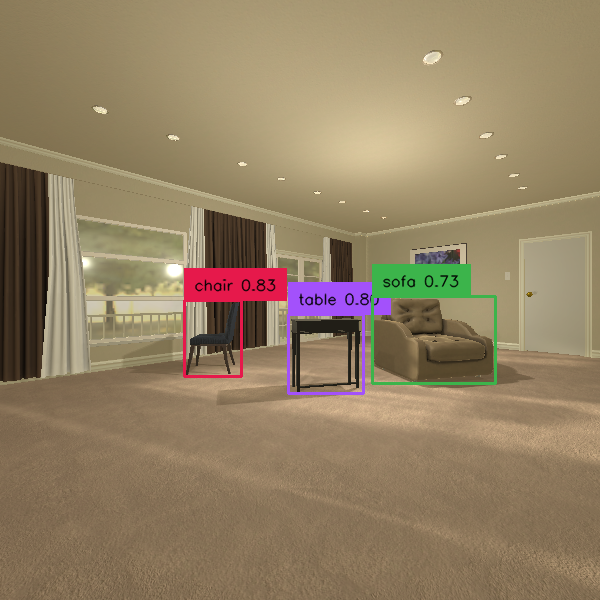

In [9]:
# download_image(image_url, local_image_path)
test_img_path = '/home2/aneesh.chavan/Change_detection/360_zip/view2/view2.png'
image_source, image = load_image(test_img_path)
Image.fromarray(image_source)

annotated_frame, detected_boxes, phrases = detect(image, text_prompt="sofa . chair . table",
                                         model=groundingdino_model,
                                         image_source=image_source)
Image.fromarray(annotated_frame)

In [10]:
# object retrieval functions

# return a tensor containing all bounding boxes
# filter for duplicates by calculating

# [TODO] speedup

import time

def getIoU(rect1, rect2):
  area_rect1 = rect1[2]*rect1[3]
  area_rect2 = rect2[2]*rect2[3]

  overlap_top_left = (max(rect1[0], rect2[0]), max(rect1[1], rect2[1]))
  overlap_bottom_right = (min(rect1[0] + rect1[2], rect2[0] + rect2[2]), min(rect1[1] + rect1[3], rect2[1] + rect2[3]))

  if (overlap_bottom_right[0] <= overlap_top_left[0]) or (overlap_bottom_right[1] <= overlap_top_left[1]):
    return 0.0  # No overlap, return 0% overlap

  # Calculate the area of the overlap rectangle
  overlap_area = abs((overlap_bottom_right[0] - overlap_top_left[0]) * (overlap_bottom_right[1] - overlap_top_left[1]))
  percent_overlap = (overlap_area / min(area_rect1, area_rect2))

  return percent_overlap

def compSize(rect1, rect2):
  area_rect1 = rect1[2]*rect1[3]
  area_rect2 = rect2[2]*rect2[3]

  diff = min(area_rect1, area_rect2)/max(area_rect1, area_rect2)
  return diff

def getAllDetectedBoxes(image, image_source=None, keywords=[], show=False, intersection_threshold=0.7, size_threshold=0.75):
  total_time = 0

  with torch.no_grad():
    boxes = []
    unique_boxes_num = 0

    for i, word in enumerate(keywords):
      af, detected, phrases = detect(image, image_source=image_source, text_prompt=str(word), model=groundingdino_model)

      cnt_time = time.time()

      # # limit edges
      # for d in detected:
      #   if d[0] + d[2] >= 1:
      #     d[2] = 1 - d[0]

      #   if d[1] + d[3] >= 1:
      #     d[3] = 1 - d[1]

      if show:
        print(i)
      unique_enough = True

      if detected != None and len(detected) != 0:
        if unique_boxes_num == 0:
          for box in detected:
            boxes.append(box)
            unique_boxes_num += 1

          if show and type(image_source) != None:
            Image.fromarray(af).show()

            if show:
              print("detected", detected)

        else:
          print("boxes: ", boxes)
          for box in detected:
            unique_enough = True

            if show:
              print("detected: ", detected)

            for prev in boxes[:unique_boxes_num]:

              iou = getIoU(box, prev)
              diff = compSize(box, prev)

              if show:
                print("comparing; -- ", prev, box)
                print("iou: ", iou)
                print("diff: ", diff)

              if (iou > intersection_threshold and diff > size_threshold):
                # bounding box is not unique enough to be added
                unique_enough = False

                if show:
                  print("failed")
                break

            if unique_enough:
              boxes.append(box)
              unique_boxes_num += 1

              if show:
                print("         success!")
                print(boxes)

          if show and type(image_source) != None:
            plt.imshow(af)

      total_time += (time.time() - cnt_time)

    # print(total_time)
    return torch.stack(boxes)
  
def decide_uniqueness(candidate_boxes, stored_boxes, intersection_threshold=0.7, size_threshold=0.75):
  # get area difference
  candidate_areas = 4 * candidate_boxes[:,2] * candidate_boxes[:,3]
  stored_areas = 4 * stored_boxes[:,2] * stored_boxes[:,3]
  minimum_areas = np.minimum(candidate_areas.unsqueeze(1), stored_areas)

  area_diff = candidate_areas.unsqueeze(1)/stored_areas
  area_diff[area_diff >= 1.] = 1/area_diff[area_diff >= 1.]

  conv_cb = candidate_boxes.clone()
  conv_sb = stored_boxes.clone()

  conv_cb[:, :2] -= conv_cb[:, 2:]
  conv_cb[:, 2:] = 2 * conv_cb[:, 2:] + conv_cb[:, :2]
  conv_cb = np.expand_dims(conv_cb, axis=1)

  conv_sb[:, :2] -= conv_sb[:, 2:]
  conv_sb[:, 2:] = 2 * conv_sb[:, 2:] + conv_sb[:, :2]

  overlap_boxes = np.concatenate([np.maximum(conv_cb[...,:2], conv_sb[...,:2]),
                                  np.minimum(conv_cb[...,2:], conv_sb[...,2:])],
                                 axis=-1)

  iou = np.where(np.logical_and((overlap_boxes[..., 2] > overlap_boxes[..., 0]), (overlap_boxes[..., 3] > overlap_boxes[..., 1])),
                 (overlap_boxes[..., 3] - overlap_boxes[..., 1]) * (overlap_boxes[..., 2] - overlap_boxes[..., 0])/minimum_areas,
                 -np.inf)

  boxes_comparison = np.where(
      np.logical_and(np.logical_and(iou > intersection_threshold, area_diff > size_threshold), iou != -np.inf),
      False,
      True
  )

  unique_enough = np.logical_and.reduce(boxes_comparison, 1)

  return unique_enough

def eff_getAllDetectedBoxes(image, image_source=None, keywords=[], show=False, intersection_threshold=0.7, size_threshold=0.75):
  with torch.no_grad():
    boxes = None
    unique_boxes_num = 0

    total_time = 0

    for i, word in enumerate(keywords):
      af, detected = detect(image, image_source=image_source, text_prompt=str(word), model=groundingdino_model)

      cnt_time = time.time()

      if show:
        print(i)
      # unique_enough = True

      # sort through all detected boxes, add them if there is little enough overlap with all recorded bboxes, or it is small enough for overlap to not matter
      if detected != None and len(detected) != 0:
        if boxes == None:
          boxes = detected

          if show and type(image_source) != None:
            Image.fromarray(af).show()

            if show:
              print("detected", detected)

        else:
          if show:
            print("boxes:\n", boxes)

            if type(image_source) != None:
              Image.fromarray(af).show()


          unique_enough = decide_uniqueness(detected, boxes)
          boxes = torch.concat([boxes] + [detected[num].unsqueeze(0) for num, val in enumerate(unique_enough) if val])

          if show:
            for i, k in enumerate(unique_enough):
              print("Added " if k else "Failed ", sep='')
              print(detected[i])


          total_time += (time.time() - cnt_time)

    print(total_time)
    return boxes
  
# segmentation code

# THERE IS SPACE TO BATCH SEGMENTATIONS

def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return boxes_xyxy, masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


In [11]:
%matplotlib inline

In [12]:
detected_boxes = getAllDetectedBoxes(image, image_source, [l for l in "sofa | chair | table".split('|')],
                                     show=False)

boxes:  [tensor([0.7235, 0.5668, 0.2040, 0.1439])]
boxes:  [tensor([0.7235, 0.5668, 0.2040, 0.1439]), tensor([0.3544, 0.5629, 0.0894, 0.1231])]


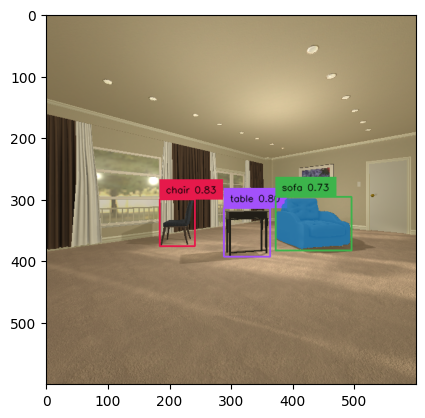

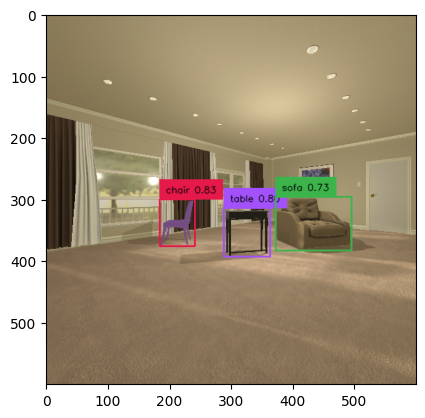

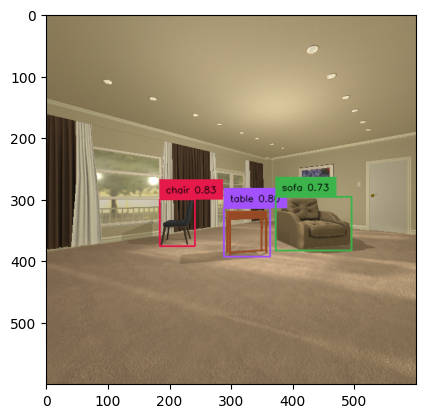

In [13]:
bboxs, masks = segment(image_source, sam_predictor, boxes=detected_boxes)

for idx in range(masks.shape[0]):
  annotated_frame_with_mask = draw_mask(masks[idx][0], annotated_frame)
  plt.figure()
  plt.imshow(annotated_frame_with_mask)
#   Image.fromarray(annotated_frame_with_mask).show()

In [14]:
bboxs

tensor([[372.8727, 296.8970, 495.2827, 383.2444],
        [185.8307, 300.8498, 239.4637, 374.6848],
        [287.8192, 313.9756, 364.1537, 393.6122]])

In [15]:
masks.shape

torch.Size([3, 1, 600, 600])

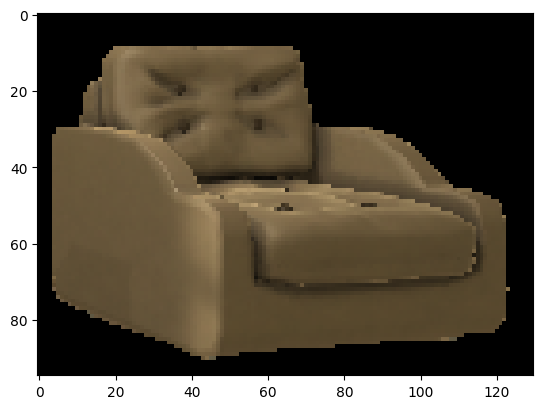

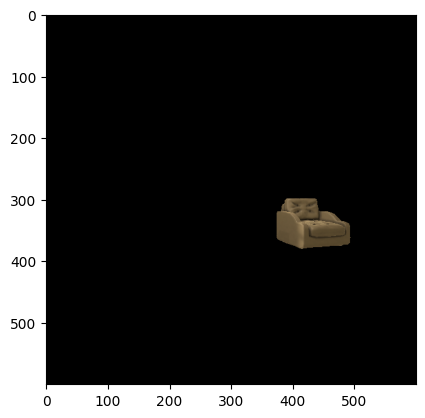

In [16]:
mt = np.copy(image_source)
mt[masks[0,0] == False] = 0
plt.imshow(mt[290:385, 370:500,  :])
plt.figure()
plt.imshow(mt)

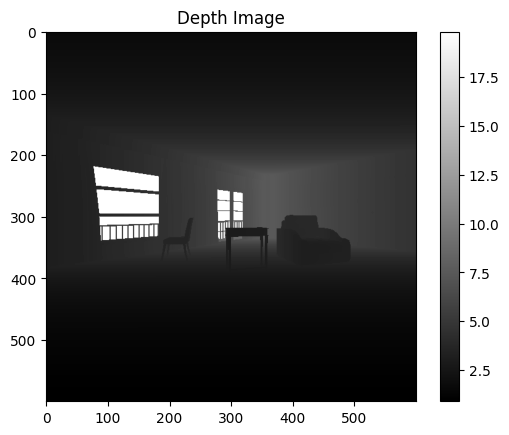

In [17]:


depth_img = np.load("360_zip/view2/view2.npy")

plt.imshow(depth_img, cmap='gray')
plt.colorbar()  # Adds a colorbar to show the depth values
plt.title("Depth Image")
plt.show()

# print(depth_img, np.max(depth_img), np.min(depth_img))



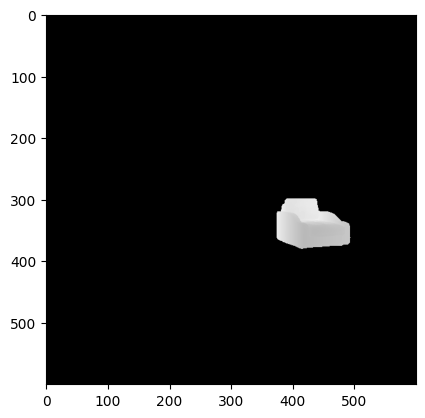

In [18]:
depth_test = np.copy(depth_img)
depth_test[(masks[0] == False).squeeze()] = 0
plt.imshow(depth_test, cmap='gray')
plt.show()

In [19]:
a = [1,2,3]
b = [1,2,3]
c = [1,2,3]
d = [1,2,3]
e = [1,2,3]

x = [[1,1,1,1,1], [1,1,1,1,1], [1,1,1,1,1], [1,1,1,1,1], [1,1,1,1,1]]
y = [[2,2,2,2,2], [2,2,2,2,2], [2,2,2,2,2], [2,2,2,2,2], [2,2,2,2,2]]
z = [[4,4,4,4,4], [4,4,4,4,4], [4,4,4,4,4], [4,4,4,4,4], [4,4,4,4,4]]

np.stack([x,y,z]).reshape(3, -1).shape

(3, 25)

In [20]:
f = 300

w, h = depth_test.shape

row_wise = np.tile(np.linspace(-h/2, h/2, h, dtype=np.float32), (w, 1))
col_wise = np.tile(np.linspace(w/2, -w/2, w, dtype=np.float32).reshape(1,-1).T, (1, h))

X = row_wise * depth_img/f
Y = col_wise * depth_img/f
Z = depth_img

# zeroth object centroid
centroid0 = np.array([
    np.where(masks[0] == True, X, 0).sum(),
    np.where(masks[0] == True, Y, 0).sum(),
    np.where(masks[0] == True, depth_img, 0).sum()
]) /np.where(masks[0] == True, 1, 0).sum()

centroid1 = np.array([
    np.where(masks[1] == True, X, 0).sum(),
    np.where(masks[1] == True, Y, 0).sum(),
    np.where(masks[1] == True, depth_img, 0).sum()
]) /np.where(masks[1] == True, 1, 0).sum()

centroid2 = np.array([
    np.where(masks[2] == True, X, 0).sum(),
    np.where(masks[2] == True, Y, 0).sum(),
    np.where(masks[2] == True, depth_img, 0).sum()
]) /np.where(masks[2] == True, 1, 0).sum()

# for i in range(w):
#   for h in range(h):
#     # X = z*x/f

X1 = np.where(masks[0] == True, X, 0).reshape(600,600)
Y1 = np.where(masks[0] == True, Y, 0).reshape(600,600)
Z1 = np.where(masks[0] == True, depth_img, 0).reshape(600,600)

pcd1 = np.stack([X1, Y1, Z1]).reshape(3, -1).T
# pcd1 = np.stack([X, Y, Z]).reshape(3, -1).T
print(pcd1.shape)

print(pcd1)

# pcd1 = pcd1[np.logical_and(pcd1[:,0] != 0. , pcd1[:,1] != 0. , pcd1[:,2] != 0.)]
# print(pcd1.shape)

# plt.figure()
# plt.title('X')
# plt.imshow(X1[:,200:])
# plt.colorbar()
# plt.show()

# plt.figure()
# plt.title('Y')
# plt.imshow(Y1[:,200:])
# plt.colorbar()
# plt.show()

# plt.figure()
# plt.title('Z')
# plt.imshow(Z1[:,200:])
# plt.colorbar()
# plt.show()


(360000, 3)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [21]:
import open3d as o3d
import plotly.graph_objects as go
import plotly

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [22]:
%matplotlib inline

pcd1_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcd1))

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(pcd1[:,0], pcd1[:,1], pcd1[:,2])
# plt.show()

from copy import copy

def save_pcd(pcd):
    pcd1_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcd1))
    o3d.io.write_point_cloud('./temppcd.pcd', pcd1_o3d)


In [23]:
save_pcd(pcd1)

# Main code

In [1]:
!mkdir -p /scratch/aneesh

import os, sys

sys.path.append(os.path.join(os.getcwd(), "Grounded-Segment-Anything"))
sys.path.append(os.path.join(os.getcwd(), "Grounded-Segment-Anything", "GroundingDINO"))
sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
sys.path.append(os.path.join(os.getcwd(), "recognize-anything"))

print(os.getcwd(), os.path.join(os.getcwd(), "Grounded-Segment-Anything", "GroundingDINO"))
print(sys.path)

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# recognise anything
from ram.models import ram
from ram import inference_ram as inference
from ram import get_transform

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

import os

# load models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

/home2/aneesh.chavan/Change_detection /home2/aneesh.chavan/Change_detection/Grounded-Segment-Anything/GroundingDINO
['/home2/aneesh.chavan/Change_detection', '/home2/aneesh.chavan/miniconda3/envs/reid/lib/python310.zip', '/home2/aneesh.chavan/miniconda3/envs/reid/lib/python3.10', '/home2/aneesh.chavan/miniconda3/envs/reid/lib/python3.10/lib-dynload', '', '/home2/aneesh.chavan/miniconda3/envs/reid/lib/python3.10/site-packages', '/home2/aneesh.chavan/Change_detection/recognize-anything', '/home2/aneesh.chavan/Change_detection/Grounded-Segment-Anything', '/home2/aneesh.chavan/Change_detection/Grounded-Segment-Anything/GroundingDINO', '/home2/aneesh.chavan/Change_detection/GroundingDINO', '/home2/aneesh.chavan/Change_detection/recognize-anything']


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import PIL
import os
import random

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

from tqdm import tqdm
from transformers import ViTConfig, ViTModel, ViTForImageClassification
from transformers import AutoImageProcessor, CLIPVisionModel

In [3]:
from peft import LoraConfig, get_peft_model

In [4]:
! mkdir -p /scratch/aneesh/
! wget -O /scratch/aneesh/sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-02-07 15:31:57--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.155.49.105, 18.155.49.54, 18.155.49.93, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.155.49.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘/scratch/aneesh/sam_vit_h_4b8939.pth’

/scratch/aneesh/sam 100%[===================>]   2.39G  43.3MB/s    in 61s     

2024-02-07 15:32:58 (40.3 MB/s) - ‘/scratch/aneesh/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [5]:
# loads a base ViT and a set of LoRa configs, allows loading and swapping between them
class LoraRevolver:
    # load base ViT, its preprocessing functions
    def __init__(self, model_checkpoint="google/vit-base-patch16-224-in21k"):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # self.base_model will be augmented with a saved set of lora_weights
        # self.lora_model is the augmented model
        self.base_model = ViTModel.from_pretrained(
            model_checkpoint,
            ignore_mismatched_sizes=True
        ).to(self.device)
        self.lora_model = self.base_model

        # image preprocessors the ViT needs
        self.image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
        self.normalize = Normalize(mean=self.image_processor.image_mean, std=self.image_processor.image_std)
        self.train_transforms = Compose(
            [
                RandomResizedCrop(self.image_processor.size["height"]),
                RandomHorizontalFlip(),
                ToTensor(),
                self.normalize,
            ]
        )
        self.test_transforms = Compose(
            [
                Resize(self.image_processor.size["height"]),
                CenterCrop(self.image_processor.size["height"]),
                ToTensor(),
                self.normalize,
            ]
        )

        # stored lora_configs, ready to be swapped in
        # only expects store lora_checkpoints.pt objects created by this class
        self.ckpt_library = {}

    # load a config into the config library from a saved file
    def load_lora_ckpt_from_file(self, config_path, name):
        ckpt = torch.load(config_path)
        try:
            self.ckpt_library[name] = ckpt
            del self.lora_model
            self.lora_model = self.get_peft_model(self.base_model,
                                                ckpt["lora_config"]).to(self.device)
            self.lora_model.load_state_dict(ckpt["lora_state_dict"], strict=False)
        except:
            print("Lora checkpoint invalid")
            raise IndexError

        self.ckpt_library[str(name): ckpt]
        
    def train_current_lora_model(self):
        pass

    def save_lora_ckpt(self):
        pass

    # use the current lora_model to encode a batch of images
    def encode_image(self, imgs):
        with torch.no_grad():
            img_batch = torch.stack([self.test_transforms(i) for i in imgs])
            # if len(img.shape) == 3:
            #     img = img.unsqueeze(0)    # if the image is unbatched, batch it
            emb = self.lora_model(img_batch.to(self.device), output_hidden_states=True).last_hidden_state[:,0,:]
        
        return emb





torch.Size([1, 768])


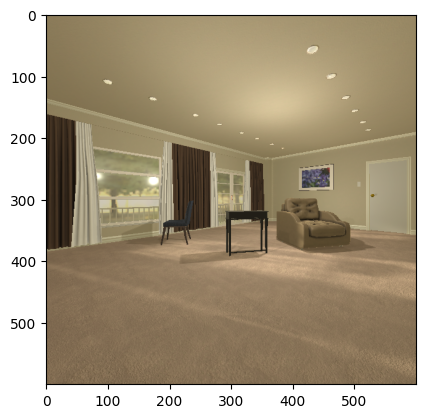

In [6]:
loraRevolver = LoraRevolver()
i = PIL.Image.open("/home2/aneesh.chavan/Change_detection/360_zip/view2/view2.png")

plt.imshow(i)

emb = loraRevolver.encode_image([i])
print(emb.shape)
# print(emb)

In [18]:
# detector and segmenter class

from GroundingDINO.groundingdino.util.inference import annotate as gd_annotate 
from GroundingDINO.groundingdino.util.inference import load_image as gd_load_image
from GroundingDINO.groundingdino.util.inference import predict as gd_predict

class ObjectFinder:
    def __init__(self, sam_checkpoint_path='/scratch/aneesh/sam_vit_h_4b8939.pth', box_threshold=0.35, text_threshold=0.55):
        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.box_threshold = box_threshold
        self.text_threshold = text_threshold

        # self._load_models(sam_checkpoint_path)


    # loads GROUNDINGDINO
    #       SAM
    #       RAM
    #       
    def _load_models(self):
        # ram
        # TODO

        # grounding dino
        ckpt_repo_id = "ShilongLiu/GroundingDINO"
        ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
        ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

        cache_config_file = hf_hub_download(repo_id=ckpt_repo_id, filename=ckpt_config_filename)
        args = SLConfig.fromfile(cache_config_file)
        args.device = device
        self.groundingdino_model = build_model(args)

        cache_file = hf_hub_download(repo_id=ckpt_repo_id, filename=ckpt_filenmae)
        checkpoint = torch.load(cache_file, map_location=device)
        log = self.groundingdino_model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
        print("Model loaded from {} \n => {}".format(cache_file, log))
        _ = self.groundingdino_model.eval()

    def _load_sam(self, sam_checkpoint_path):
        # segment anything
        self.sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint_path).to(self.device))
        # self.sam_predictor.to(self.device)
        self.sam_predictor.eval()
        print("SAM loaded")

    def _getIoU(self, rect1, rect2):
        area_rect1 = rect1[2]*rect1[3]
        area_rect2 = rect2[2]*rect2[3]

        overlap_top_left = (max(rect1[0], rect2[0]), max(rect1[1], rect2[1]))
        overlap_bottom_right = (min(rect1[0] + rect1[2], rect2[0] + rect2[2]), min(rect1[1] + rect1[3], rect2[1] + rect2[3]))

        if (overlap_bottom_right[0] <= overlap_top_left[0]) or (overlap_bottom_right[1] <= overlap_top_left[1]):
            return 0.0  # No overlap, return 0% overlap

        # Calculate the area of the overlap rectangle
        overlap_area = abs((overlap_bottom_right[0] - overlap_top_left[0]) * (overlap_bottom_right[1] - overlap_top_left[1]))
        percent_overlap = (overlap_area / min(area_rect1, area_rect2))

        return percent_overlap

    def _compSize(sefl, rect1, rect2):
        area_rect1 = rect1[2]*rect1[3]
        area_rect2 = rect2[2]*rect2[3]

        diff = min(area_rect1, area_rect2)/max(area_rect1, area_rect2)
        return diff

    # given a phrase, filter and get all boxes and phrases
    def getBoxes(self, image, text_prompt, show=False, intersection_threshold=0.7, size_threshold=0.75):
        total_time = 0

        keywords = [k.strip() for k in text_prompt.split('.')]
        # print(text_prompt, keywords)

        with torch.no_grad():
            boxes = []
            phrases = []
            unique_boxes_num = 0

            for i, word in enumerate(keywords):
                # af, detected, detected_phrases = self._detect(image, image_source=image_source, text_prompt=str(word))

                detected, _, detected_phrases = gd_predict(
                    model=self.groundingdino_model,
                    image=image,
                    caption=str(word),
                    box_threshold=self.box_threshold,
                    text_threshold=self.text_threshold
                )

                phrases.append(detected_phrases[0])

                if show:
                    print(i)
                unique_enough = True

                if detected != None and len(detected) != 0:
                    if unique_boxes_num == 0:
                        for box in detected:
                            boxes.append(box)
                            unique_boxes_num += 1

                        # if show and type(image_source) != None:
                        #     Image.fromarray(af).show()

                        #     if show:
                        #         print("detected", detected)

                    else:
                        # print("boxes: ", boxes)
                        for box in detected:
                            unique_enough = True

                            # if show:
                            #     print("detected: ", detected)

                            for prev in boxes[:unique_boxes_num]:
                                iou = self._getIoU(box, prev)
                                diff = self._compSize(box, prev)

                                # if show:
                                #     print("comparing; -- ", prev, box)
                                #     print("iou: ", iou)
                                #     print("diff: ", diff)

                                if (iou > intersection_threshold and diff > size_threshold):
                                    # bounding box is not unique enough to be added
                                    unique_enough = False

                                    # if show:
                                    #     print("failed")
                                    #     break

                            if unique_enough:
                                boxes.append(box)
                                unique_boxes_num += 1

                                # if show:
                                #     print("         success!")
                                #     print(boxes)

                        # if show and type(image_source) != None:
                        #     plt.imshow(af)

            return torch.stack(boxes), phrases

    def segment(self, image, boxes):
        with torch.no_grad():
            self.sam_predictor.set_image(image)
            H, W, _ = image.shape
            boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

            transformed_boxes = self.sam_predictor.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
            masks, _, _ = self.sam_predictor.predict_torch(
                point_coords = None,
                point_labels = None,
                boxes = transformed_boxes,
                multimask_output = False,
                )
            return boxes_xyxy, masks

    # # use the saved model to return grounded images, bounding boxes, masks and phrases
    def find(self, image_path=None, caption=None):
        if type(image_path) == None:
            raise NotImplementedError
        else:
            image_source, image = gd_load_image(image_path)
        
        # get object names
        if caption == None:
            caption = "sofa . chair . table"    # TODO replace with RAM
        
        # ground them, get associated phrases
        cxcy_boxes, phrases = self.getBoxes(image, caption)

        boxes, masks = self.segment(image_source, cxcy_boxes)

        # if type(image_source) == None:
        #     annotated_frame = None
        # else:
        #     annotated_frame = gd_annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
        #     annotated_frame = annotated_frame[...,::-1] # BGR to RGB

        # ground objects
        grounded_objects = [image_source[bb[1]:bb[3], bb[0]:bb[2], :] for bb in boxes]

        return grounded_objects, boxes, masks, phrases
    
    # return a 3xN pointcloud corresponding to each object
    def getDepth(depth_image_path, masks, f=300):
        if depth_image_path == None:
            raise NotImplementedError
        else:
            depth_image = np.load(depth_image_path)
            
            w, h = depth_image.shape
            num_objs = masks.shape[0]

            stacked_depth = np.tile(depth_image, (num_objs, 1, 1)) # get all centroids/pcds together
            stacked_depth[masks == False] = 0

            horizontal_distance = np.tile(np.linspace(-h/2, h/2, h, dtype=np.float32), (num_objs, w,1))
            vertical_distance =   np.tile(np.linspace(w/2, -w/2, w, dtype=np.float32).reshape(1,-1).T, (num_objs, 1, h))

            X = horizontal_distance * depth_image/f
            Y = vertical_distance * depth_image/f
            Z = stacked_depth

            # combine caluclated X,Y,Z points
            all_pointclouds = np.stack([X, Y, Z], 1).reshape((num_objs, 3, -1))

            # filter out [0,0,0]
            all_pointclouds = [pcd[:, pcd[2, :] != 0] for pcd in all_pointclouds]
            
            return all_pointclouds



    def _show_detections(self, image_path=None, caption=None):
        if type(image_path) == None:
            raise NotImplementedError
        else:
            image_source, image = gd_load_image(image_path)

        ## TODO implement RAM
        if caption==None:
            caption = "sofa . chair . table"

        Image.fromarray(image_source)
        b, l, p = gd_predict(model=self.groundingdino_model, 
                                           image=image, caption="sofa . chair . table",
                                           box_threshold=0.35,
                                           text_threshold=0.55)
        af = gd_annotate(image_source=image_source, boxes=b, logits=l, phrases=p)[...,::-1]
        Image.fromarray(af)
        plt.imshow(af)


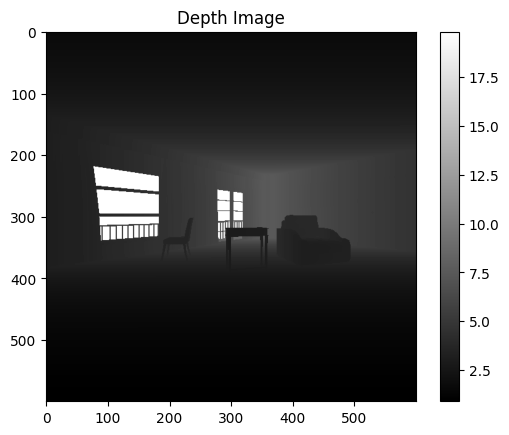

In [8]:
import numpy as np
import matplotlib.pyplot as plt

depth_img = np.load("360_zip/view2/view2.npy")

plt.imshow(depth_img, cmap='gray')
plt.colorbar()  # Adds a colorbar to show the depth values
plt.title("Depth Image")
plt.show()

In [9]:
mask = np.ones((2, depth_img.shape[0], depth_img.shape[1]))
mask[0,:, :] = 0
mask[0:, 300:500, 300:500] = 1
# mask[1, 300:500, :400] = 1
# mask[1, 400:450, 200:300]=0

In [10]:
def getDepth(depth_image_path, masks, f=300):
    if depth_image_path == None:
        raise NotImplementedError
    else:
        depth_image = np.load(depth_image_path)
        
        w, h = depth_image.shape
        num_objs = masks.shape[0]

        stacked_depth = np.tile(depth_image, (num_objs, 1, 1)) # get all centroids/pcds together
        stacked_depth[masks == False] = 0

        horizontal_distance = np.tile(np.linspace(-h/2, h/2, h, dtype=np.float32), (num_objs, w,1))
        vertical_distance =   np.tile(np.linspace(w/2, -w/2, w, dtype=np.float32).reshape(1,-1).T, (num_objs, 1, h))

        X = horizontal_distance * depth_image/f
        Y = vertical_distance * depth_image/f
        Z = -stacked_depth

        print(X.shape)

        # combine caluclated X,Y,Z points
        # filter out [0,0,0]
        all_pointclouds = np.stack([X, Y, Z], 1).reshape((num_objs, 3, -1))
        all_pointclouds = [pcd[:, pcd[2, :] != 0] for pcd in all_pointclouds]
        for p in all_pointclouds:
            print(p.shape)

        print(len(all_pointclouds), all_pointclouds[0].shape, all_pointclouds[1].shape)

        # all_pointclouds = all_pointclouds[np.where(all_pointclouds[:, 2, :] != 0)]
        
        return all_pointclouds
        # swapaxes((0,1)).reshape(3, num_objs, -1)

apcd = getDepth('360_zip/view2/view2.npy', mask)

(2, 600, 600)
(3, 40000)
(3, 360000)
2 (3, 40000) (3, 360000)


In [11]:
import open3d as o3d

k = apcd[1]
# k[:,1] = 0
# print(k[0].T.shape)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(k.T)
# o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [12]:
objectFinder = ObjectFinder()
objectFinder._load_models()

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home2/aneesh.chavan/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


In [17]:
objectFinder._load_sam('/scratch/aneesh/sam_vit_h_4b8939.pth')

AttributeError: 'SamPredictor' object has no attribute 'to'

In [16]:
from copy import deepcopy

test_img_path = '/home2/aneesh.chavan/Change_detection/360_zip/view2/view2.png'
image_source, image = load_image(test_img_path)
Image.fromarray(image_source)

bb, msk, phr = objectFinder.find(test_img_path, caption="table . sofa")

# objectFinder._show_detections(test_img_path)
# print(bb)
# print()
# print(msk)
# print()
print(phr)
# print()

for i, k in enumerate(bb):
    mt = deepcopy(image_source)
    mt[msk[i,0].cpu() == False] = 255
    c = [int(l) for l in k]
    print(c)
    print(msk[i,0].any())
    # print(mt[min(c[1], c[0]):max(c[0], c[1]), 
    #          min(c[3], c[2]):max(c[2], c[3]),  :].shape)
    plt.imshow(mt[min(c[3], c[1]):max(c[3], c[1]), 
                  min(c[2], c[0]):max(c[2], c[0]), 
                  :])

    plt.figure()

error in ms_deformable_im2col_cuda: no kernel image is available for execution on the device
error in ms_deformable_im2col_cuda: no kernel image is available for execution on the device
error in ms_deformable_im2col_cuda: no kernel image is available for execution on the device
error in ms_deformable_im2col_cuda: no kernel image is available for execution on the device
error in ms_deformable_im2col_cuda: no kernel image is available for execution on the device
error in ms_deformable_im2col_cuda: no kernel image is available for execution on the device
error in ms_deformable_im2col_cuda: no kernel image is available for execution on the device
error in ms_deformable_im2col_cuda: no kernel image is available for execution on the device
error in ms_deformable_im2col_cuda: no kernel image is available for execution on the device
error in ms_deformable_im2col_cuda: no kernel image is available for execution on the device
error in ms_deformable_im2col_cuda: no kernel image is available for e

IndexError: list index out of range

In [15]:
torch.version.cuda

'12.1'

In [ ]:
print(msk.shape)

torch.Size([2, 1, 600, 600])


In [ ]:
from scipy.spatial.transform import Rotation

# Utility functions
"""
Given a point cloud and an [x y z qw qx qy qz] pose in a frame, transform a pcd into that frame
"""
def transform_pcd_to_global_frame(pcd, pose):
    t = pose[:3]
    q = pose[3:]

    q /= np.linalg.norm(q)                  # normalise
    R = Rotation.from_quat(q).as_matrix()

    transformed_pcd = R @ pcd
    transformed_pcd += t

    return transformed_pcd

"""
Assume 3xN pcds, 
"""
def calculate_3d_IoU(pcd1, pcd2):
    # get [min_X, min_Y, min_Z, max_X, max_Y, max_Z] for both pcds
    bb1_min = pcd1.min(axis=-1)
    bb1_max = pcd1.max(axis=-1)

    bb2_min = pcd2.min(axis=-1)
    bb2_max = pcd2.max(axis=-1)

    overlap_min_corner = np.stack([bb1_min, bb2_min], axis=0).min(axis=0)
    overlap_max_corner = np.stack([bb1_max, bb2_max], axis=0).max(axis=0)

    # no overlap case
    if (overlap_min_corner > overlap_max_corner).any():
        return 0
    else:
        v = overlap_max_corner - overlap_min_corner
        overlap_volume = v[0] * v[1] * v[2]
        
        bb1 = bb1_max - bb1_min
        bb2 = bb2_max - bb2_min

        v1 = bb1[0] * bb1[1] * bb1[2]
        v2 = bb2[0] * bb2[1] * bb2[2]

        v = overlap_volume/(v1 + v2 - overlap_volume)

        return v


# Classes
"""
Bundles together object information for distinct objects
"""
class ObjectInfo:
    def __init__(self, id, name, emb, pcd):
        self.id = id
        self.names = [name]
        self.embeddings = [emb]
        self.pcd = pcd
        # self.centroid = np.empty(3, np.float64)

    def addInfo(self, name, embedding, pcd):
        if name not in self.names:
            self.names.append(name)
        self.embeddings.append(embedding)
        self.pcd = torch.tile([self.pcd, pcd], axis=-1)

    def __repr__(self):
        return f"ID: %d | Names: [%s] |  Num embs: %d | Pcd size: " % \
              (self.id, " ".join(self.names), len(self.embeddings)) + str(self.pcd.shape)

# main object recorder class

# stores all object information, point clouds, embeddings etc
"""

"""
class ObjectMemory:
    def __init__(self, lora_path=None):
        self.objectFinder = ObjectFinder()
        self.loraModule = LoraRevolver()

        if lora_path != None:
            self.loraModule.load_lora_ckpt_from_file(lora_path)

        self.num_objects_stored = 0
        self.memory = {
            # store ObjectInfo classes here
        }

        pass

    # visualisation and utility
    def view_memory(self):
        for _, info in self.memory:
            print(info)

    """
     takes in an rgb-d image and associated pose, detects all objects present, stores into memory
    """
    def process_image(self, image_path=None, pose=None, bounding_box_threshold=0.3):
        if image_path == None:
            raise NotImplementedError
        
        else:
            # segment objects, get (grounded_image bounding boxes, segmentation mask and label) per box
            obj_grounded_imgs, obj_bounding_boxes, obj_masks, obj_phrases = self.objectFinder.find(image_path)
            
            # get ViT+LoRA embeddings, use bounding boxes and the image to get grounded images
            embs = self.loraModule.encode_image(obj_grounded_imgs)

            obj_pointclouds = self.objectFinder.getDepth(obj_masks)
            transformed_pointclouds = [transform_pcd_to_global_frame(pcd, pose) for pcd in obj_pointclouds]

            # check that all info recovered
            assert(len(obj_grounded_imgs) == len(obj_bounding_boxes) \
                   and len(obj_bounding_boxes) == len(obj_masks) \
                   and len(obj_masks) == len(obj_phrases) \
                   and len(embs) == len(obj_phrases))

            # for each tuple, consult already stored memory, match tuples to stored memory (based on 3d IoU)
                # TODO optimise and batch, fetch all memory bounding boxes once
                # remove double loop
            
            for obj_phrase, emb, q_pcd in zip(obj_phrases, embs, transformed_pointclouds):
                for instance_id, info in self.memory:
                    object_pcd = info.pcd
                    IoU3d = calculate_3d_IoU(q_pcd, object_pcd)

                    # if the iou is above the threshold, consider it to be the same object
                    if IoU3d > bounding_box_threshold:
                        instance_id.addInfo(obj_phrase ,emb, q_pcd)
                    else:   # new object detected
                        new_obj_info = ObjectInfo(self.num_objects_stored,
                                                  obj_phrase,
                                                  emb,
                                                  q_pcd)
                        
                        self.memory[self.num_objects_stored] = new_obj_info
                        self.num_objects_stored += 1



